## RTK + GG Visualization
#### April Novak

This notebook illustrates how to visualize a combined RTK (in-core) and GG (ex-core) geometry. This notebook is held on `orthanc`, but is launched through the Mounts, so my personal machine has to have the `casl2omni` branch checked out so that my machine knows about those updates. To do this, from `~/projects/Exnihilo`, do `git fetch; git checkout -t origin/casl2omni`. Then, build in the build directory on my personal machine (`~/Builds/Exnihilo`) by doing `make install`. Then, because this notebook is being launched from a Mount, the file path in the `ex-core.gg.xml` file that is to be read in must be edited so that the correct path (_through the Mount_) is read.


In [1]:
import sys

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# path to Exnihilo-specific python modules on your machine. This is a path
# on a personal machine due to the mounting to orthanc.
sys.path.insert(0, '/Users/aprilnovak/Installs/python')

import exnihilotools.matplotlib as extools

extools.screen_style()
%matplotlib inline

In [2]:
# for plotting tallies
from omnibus.data import plot
from matplotlib.colors import Normalize, LogNorm

In [3]:
# This shows where this notebook is importing geometria from
import geometria
geometria.__file__

'/Users/aprilnovak/Installs/python/geometria.py'

In [4]:
# for plotting geometry
from geometria import GG_Geometry
from omnibus.raytrace.colors import ColorMap
from omnibus.raytrace.imager import Imager
from omnibus.raytrace.load import load_gg

In [5]:
xml_path = '/Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/ex-core-roomy/'
# Because this is launched through the Mount, you have to manually edit the file path within 
# the XML file so that it is reading from the Mount.
filename = 'ex-core-notebook.gg.xml'

model = load_gg(xml_path + filename)

In [6]:
# record description of the model
description = model.geometry.describe()

In [7]:
# Set parameters for the plots
tracer = 'cell'
color_map = 'CMRmap'

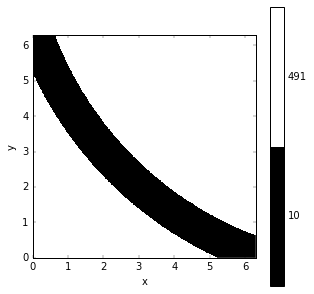

In [8]:
z = 0.5
x = 1.26*5
y = 1.26*5

# plot using a method where you can specify the lower left corner and the 
# upper right corner of the desired domain
imager = Imager(model.geometry, lower = (0.0, 0.0, z), upper = (x, y, z), \
                basis = (1, 0, 0), max_pixels=600)
imager.plot(figsize=(5.0, 5.0), cmap=cm.get_cmap(color_map));

IndexError: list index out of range

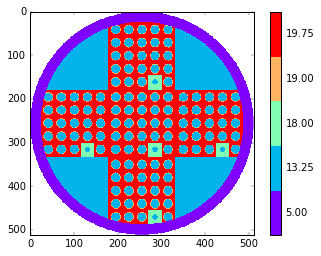

In [9]:
# plot a slice through the domain
imager = Imager.from_extents(model.geometry, z=0.5)
imager.trace = tracer
imager.plot();